# **Modelo con Random Forest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## **Descarga del Dataset original**

Para descargar el dataset a Colab, es necesario subir su Kaggle API Key personal (para crear una nueva, revise la sección Authentication en https://www.kaggle.com/docs/api).

Suba a continuación el archivo `.json` generado.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniellujanagudelo","key":"e0f7fc0287fd836756e720097ec0469f"}'}

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

 99% 682M/688M [00:08<00:00, 104MB/s]
100% 688M/688M [00:08<00:00, 80.6MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/home-credit-default-risk.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## **Preprocesamiento**

La siguiente función realiza todo el preprocesamiento necesario a los datos, explicado en [01 - Preprocesamiento.ipynb](https://colab.research.google.com/drive/1w9a0auNVqZ2hN_urrf3rmJ-3gVfDUBx0#scrollTo=2c5ymp78xowc)

In [ ]:
def preprocess_data(data: pd.DataFrame, test_data: pd.DataFrame):
    def fill_nan_with_mode(column):
        mode = column.mode()[0]
        return column.fillna(mode)
    data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
    test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)
    cat_columns = data.select_dtypes(include=["object"])
    data_encoded = pd.get_dummies(data, columns=cat_columns.columns)
    test_data_encoded = pd.get_dummies(test_data, columns=cat_columns.columns)

    return data_encoded, test_data_encoded

data, test_data = preprocess_data(pd.read_csv("/content/application_train.csv"), pd.read_csv("/content/application_test.csv"))

<ipython-input-7-c319868e6578>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
<ipython-input-7-c319868e6578>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)


## **Primera iteración**

Antes de entrenar el modelo, es necesario sincronizar la data de entrenamiento y de prueba, ya que debido al preprocesamiento, pueden tener diferentes columnas.

In [ ]:
X_train = data.drop("TARGET", axis=1)
y_train = data["TARGET"]

In [ ]:
for col in X_train.columns.difference(test_data.columns):
    test_data[col] = [0] * len(test_data)

test_data = test_data[X_train.columns]

Una vez `test_data_encoded` y `X_train` coinciden en columnas, podemos entrenar un modelo.

Para nuestra primera iteración, decidimos utilizar `RandomForestClassifier` con todos sus parámetros por defecto.

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Luego de entrenar el modelo, podemos realizar la predicción con los datos proveídos por la competencia de Kaggle.

In [ ]:
y_pred = model.predict_proba(test_data)

### **Generación del CSV con los resultados**

In [ ]:
df = pd.DataFrame()

In [ ]:
df["SK_ID_CURR"] = test_data["SK_ID_CURR"]
df["TARGET"] = y_pred[:, 1]
df = df.set_index("SK_ID_CURR")

In [ ]:
df

,TARGET
SK_ID_CURR,
100001,0.11
100005,0.11
100013,0.08
100028,0.06
100038,0.10
...,...
456221,0.08
456222,0.08
456223,0.09


In [ ]:
df.to_csv("results.csv")

Con la predicción obtenida, se consiguió un puntaje de `69.582%`
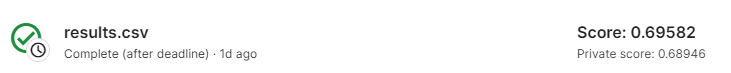

### **Análisis de los resultados**


Lo esperable es que el promedio en las probabilidades obtenidas sea similar al porcentaje de clientes que pagaron dentro del plazo en los datos de entrenamiento (porcentaje de 1s en `data`).

In [ ]:
y_pred[:, 1].mean()

0.08538835548990645

In [ ]:
data["TARGET"].mean()

0.08072881945686496

Efectivamente, se puede observar que `8.54% ~ 8.07%`.

### **Variables más significativas**

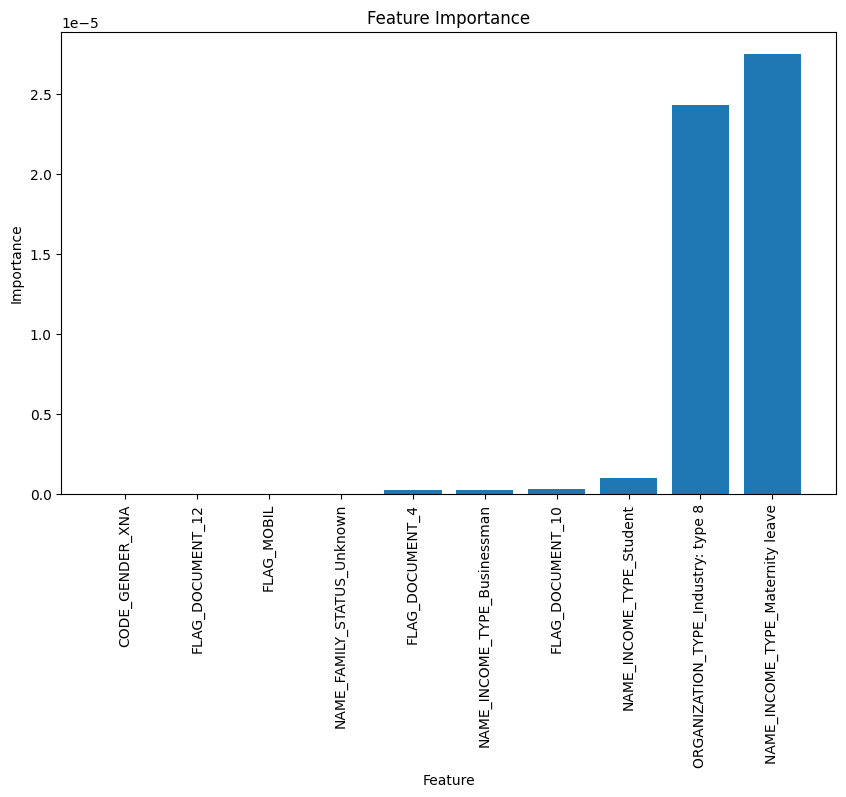

In [ ]:
combined = list(zip(model.feature_importances_, list(X_train.columns)))
combined.sort()

feature_importances, feature_names = zip(*combined)

plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importances[0:10], tick_label=feature_names[:10])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

## **Mejores Hiperparámetros**

In [ ]:
rf_classifier = RandomForestClassifier()

param_grid = {'n_estimators': [10, 50, 100, 200], 'max_depth': [10, 20]}

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20],
                         'n_estimators': [10, 50, 100, 200]})

In [ ]:
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 100}

Por lo tanto, los mejores hiperparámetros (de los probados) para este modelo son `n_estimators = ` y `max_depth = `

Los resultados usando estos parámetros

## **Predicción con los hiperparámetros encontrados**

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [ ]:
y_pred = model.predict_proba(test_data)

In [ ]:
df = pd.DataFrame()

In [ ]:
df["SK_ID_CURR"] = test_data["SK_ID_CURR"]
df["TARGET"] = y_pred[:, 1]
df = df.set_index("SK_ID_CURR")

In [ ]:
df

,TARGET
SK_ID_CURR,
100001,0.110253
100005,0.081627
100013,0.060145
100028,0.062798
100038,0.118201
...,...
456221,0.042640
456222,0.099744
456223,0.053008


In [ ]:
df.to_csv("results.csv")

### **Resultados**

Con estos parámetros, se obtuvo un puntaje `~70.46%`:

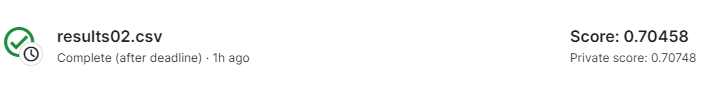

## **Curva de Aprendizaje del modelo**

In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Generate learning curves
res = learning_curve(
    model, X_train, y_train, cv=cv, n_jobs=-1, train_sizes=[0.1, 0.35, 0.6, 1.0]
)

In [ ]:
train_sizes = res[0]
train_scores = res[1]
test_scores = res[2]

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

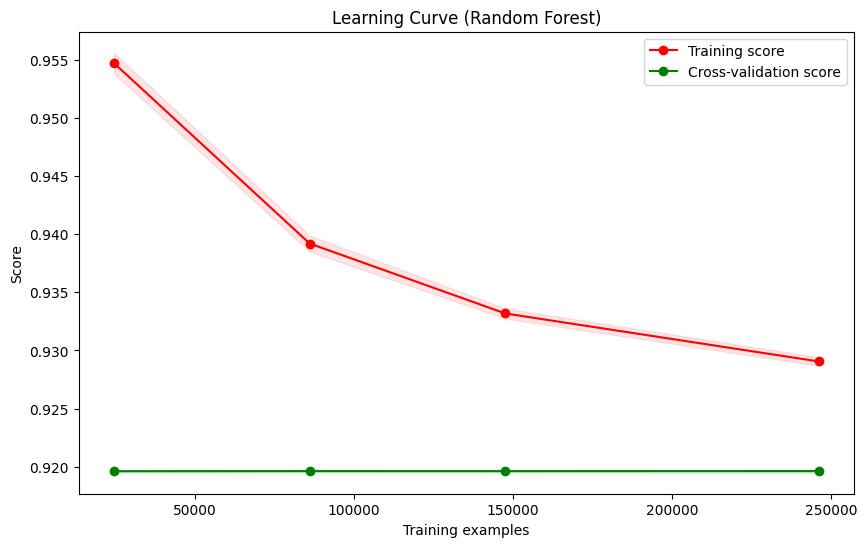

In [ ]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (Random Forest)")
plt.show()

La gráfica obtenida indica que mientras mayor es la cantidad de datos de entrenamiento, peores resultados se obtienen. Parece indicar que el modelo no está siendo capaz de captar la profundidad de los datos y la relación entre ellos. Esto se puede deber a que el modelo es muy simple, mientra que los datos de entrenamiento son más complejos.